In [119]:
import matplotlib.pyplot as plt
import numpy as np

'''

Given some guess of the source of direction we can shift the carrier frequency
phase of received samples at the N different receivers. If the guess of the
source direction is correct, the signal from the N different receivers should
interfer constructively.

'''

c=3e8 # speed of light
import sys
sys.path.append("/Users/miskodzamba/Dropbox/research/gits/")
import importlib
import spf.software.model_training_and_inference.utils.rf as rf
importlib.reload(rf)


<module 'spf.software.model_training_and_inference.utils.rf' from '/Users/miskodzamba/Dropbox/research/gits/spf/software/model_training_and_inference/utils/rf.py'>

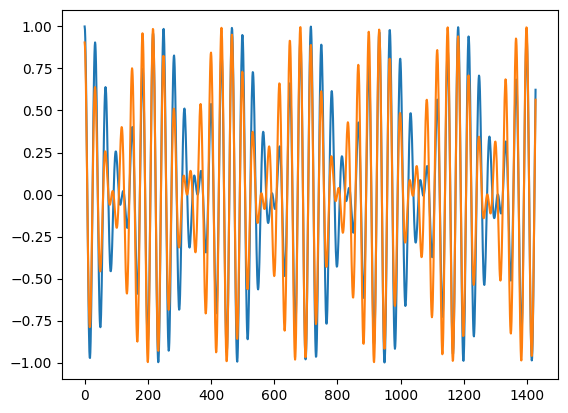

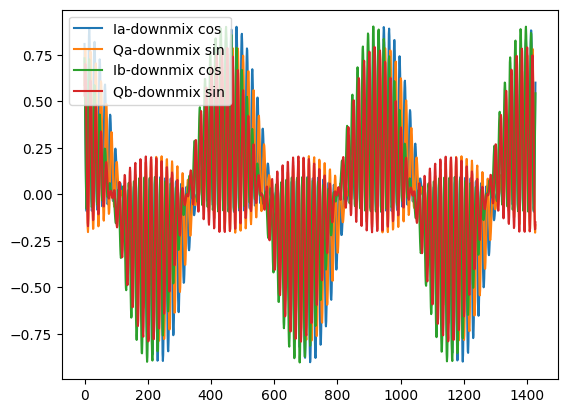

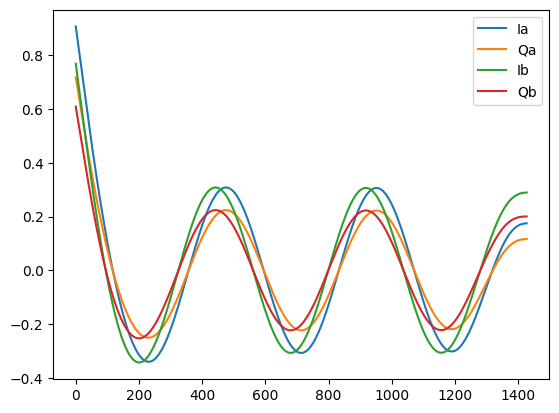

In [106]:
import numpy as np
import matplotlib.pyplot as plt
fc=100
fs=fc*100 # 100 samples per period
fi=7
lambdac=c/fc
lambdai=c/fi
periodi=1.0/fi
periodc=1.0/fc
samples_per_periodc=int(periodc*fs)
samples_per_periodi=int(periodi*fs)


def signal_at_time(time_offset):
    ts=np.linspace(0,3*periodi,samples_per_periodi)+time_offset
    i=np.cos(2*np.pi*fi*ts)
    q=0
    return i*np.cos(2*np.pi*fc*ts)+q*np.sin(2*np.pi*fc*ts)
    

#lets assume the same signal received
def process_recv(_signal,time_offset=0):
    time_offset=0 +periodc*0.1 # cannot recover IQ if no phase lock
    _downmix_cos=_signal*np.cos(2*np.pi*fc*(ts+time_offset))
    _downmix_sin=_signal*np.sin(2*np.pi*fc*(ts+time_offset))
    b,a=scipy.signal.butter(2,fi*4,btype='low',fs=fs)
    _filt_downmix_cos=scipy.signal.filtfilt(b,a,_downmix_cos)
    _filt_downmix_sin=scipy.signal.filtfilt(b,a,_downmix_sin)
    return {
        'Iraw':_downmix_cos,
        'Qraw':_downmix_sin,
        'I':_filt_downmix_cos,
        'Q':_filt_downmix_sin
    }


#raw signal sent out
fig,ax=plt.subplots(1,1)
signal_senta=signal_at_time(0)
signal_sentb=signal_at_time(periodc)
ax.plot(signal_senta)
ax.plot(signal_sentb)

rsignala=process_recv(signal_senta)
rsignalb=process_recv(signal_sentb)

fig,ax=plt.subplots(1,1)
ax.plot(rsignala['Iraw'],label='Ia-downmix cos')
ax.plot(rsignala['Qraw'],label='Qa-downmix sin')
ax.plot(rsignalb['Iraw'],label='Ib-downmix cos')
ax.plot(rsignalb['Qraw'],label='Qb-downmix sin')
ax.legend()

import scipy
fig,ax=plt.subplots(1,1)
ax.plot(rsignala['I'],label='Ia')
ax.plot(rsignala['Q'],label='Qa')
ax.plot(rsignalb['I'],label='Ib')
ax.plot(rsignalb['Q'],label='Qb')
ax.legend()


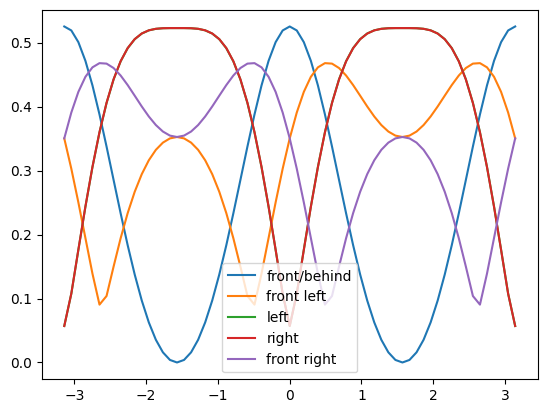

In [153]:

pos=np.array([
    [lambdac/4,0], # location of a
    [-lambdac/4,0] # locaiton of b
])

offset_and_label=[
    [(0,0),'front/behind'],
    [(0,periodc/4),'front left'], # b gets signal before a, 
    [(0,periodc/2),'left'],
    [(periodc/2,0),'right'],
    [(periodc/4,0),'front right'],
]

for offset,label in offset_and_label:
    #signal b is half a carrier wavelength ahead of signal a
    rsignala=process_recv(signal_at_time(offset[0]))
    rsignalb=process_recv(signal_at_time(offset[1]))
    signal_matrix=np.vstack([
        rsignala['I']+1j*rsignala['Q'],
        rsignalb['I']+1j*rsignalb['Q']])
    
    thetas,sds,steer=rf.beamformer(
        pos,
        signal_matrix,
        fc)
    plt.plot(thetas,sds,label=label)

plt.legend()


In [421]:
d=rf.ULADetector(sampling_frequency=1e6,n_elements=2,spacing=6)

In [422]:

importlib.reload(rf)

from scipy import signal
from numpy import convolve as np_convolve

sample_rate=11.2e6
channel_frequency=100e3
carrier_frequency=1.2e9


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)
    
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

x=100
y=10
qam=rf.QAMSource(np.array([x,y]),
               signal_frequency=channel_frequency,
               sigma=0,
               IQ=(0.1,1.0),
                h = signal.firwin(numtaps=151, cutoff=channel_frequency, fs=sample_rate)
              )
q=rf.CarrierSource(np.array([x,y]),
                   carrier_frequency,
                   qam,
                h = signal.firwin(numtaps=11, cutoff=channel_frequency, fs=sample_rate) #, width=0.01)
                  )


cut_off = channel_frequency # Hz

#t=np.linspace(0,20e-6,1000)
t=np.arange(0,3.0/channel_frequency,1.0/sample_rate).reshape(1,-1)

# create our low pass filter
qam_signal=qam.signal(t)
qam_signal_I=qam.lo_in_phase.signal(t)*qam.IQ[0]
qam_signal_Q=qam.lo_out_of_phase.signal(t)*qam.IQ[1]
emitted_signal=q.signal(t)

demod_s_nofil=q.demod_signal(emitted_signal,t,use_filter=False,nested=True)
demod_s_fil=q.demod_signal(emitted_signal,t,use_filter=True,nested=True)
#demod_s_fil=q.demod_signal(s,t,h=h)

car=q.carrier_source.signal(t).reshape(1,-1)


In [423]:
qam_signal_I.shape

(1, 336)

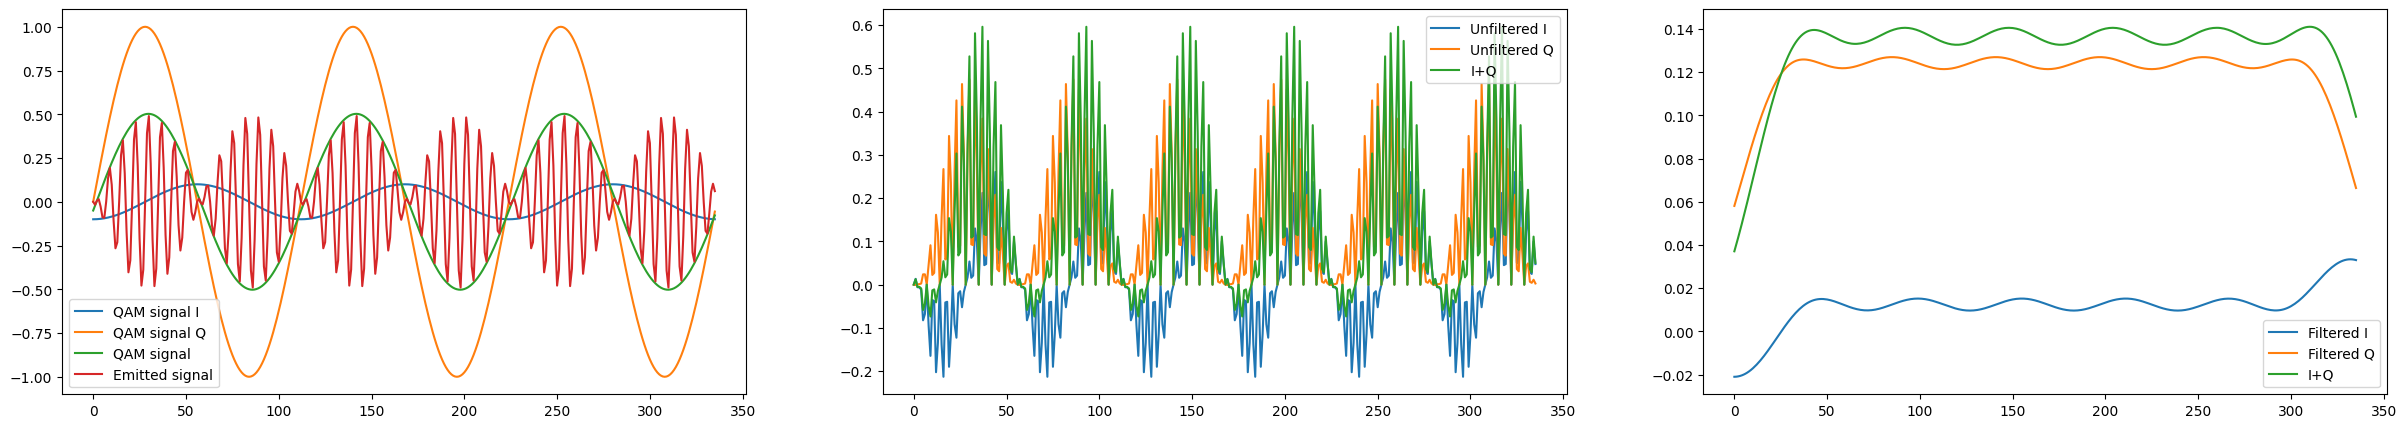

In [424]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,3,figsize=(30,5))

ax[0].plot(qam_signal_I[0],label="QAM signal I")
ax[0].plot(qam_signal_Q[0],label="QAM signal Q")
ax[0].plot(qam_signal[0],label="QAM signal")
ax[0].plot(emitted_signal[0],label="Emitted signal")
#ax[0].plot(car[0],label="Carrier signal")
ax[1].plot(demod_s_nofil.real[0],label="Unfiltered I")
ax[1].plot(demod_s_nofil.imag[0],label="Unfiltered Q")
ax[1].plot(demod_s_nofil.real[0]+demod_s_nofil.imag[0],label="I+Q")
ax[2].plot(demod_s_fil.real[0],label="Filtered I")
ax[2].plot(demod_s_fil.imag[0],label="Filtered Q")
ax[2].plot(demod_s_fil.real[0]+demod_s_fil.imag[0],label="I+Q")
#ax[1].set_ylim([0,None])
#ax[2].set_ylim([0,None])

ax[0].legend()
ax[1].legend()
ax[2].legend()

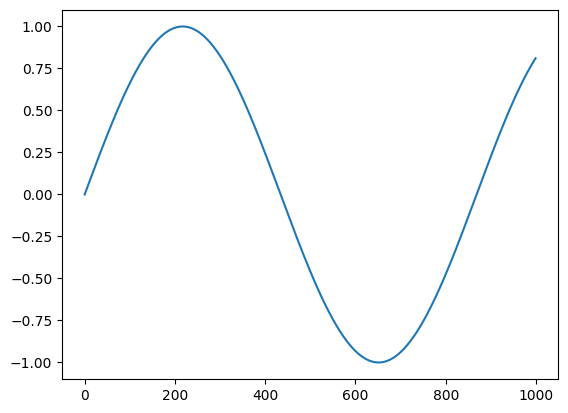

In [425]:
t=np.linspace(0,1,1000)
x=np.sin(2*np.pi*20*t)
x=np.sin(2*np.pi*(20%(2*np.pi))*t)
#print(x)
plt.plot(x)

4.783542904563622 11.548494156391085
[[-0.03125  0.     ]
 [ 0.03125  0.     ]]
NOT NESTED


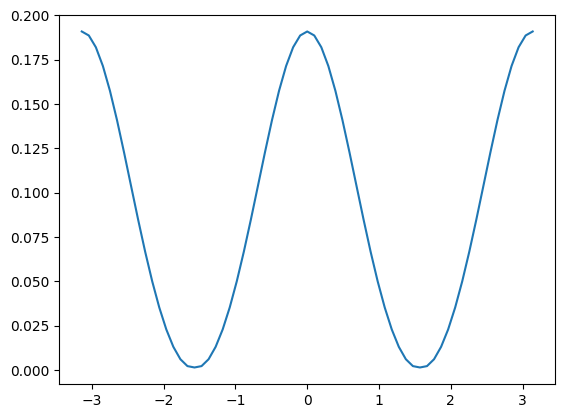

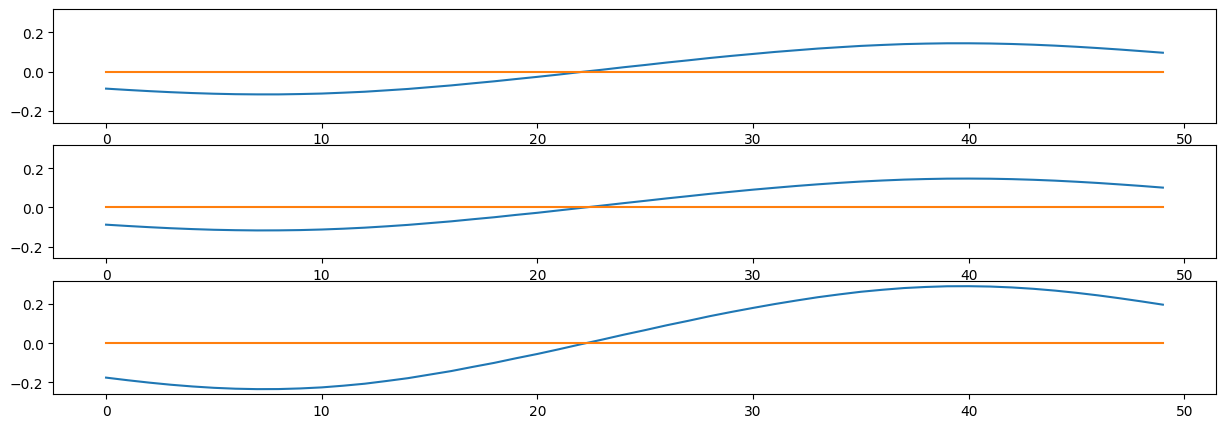

In [429]:

import rf
importlib.reload(rf)
sample_rate=9.1e6
channel_frequency=100e3
carrier_frequency=2.4e9

wavelength=c/carrier_frequency



theta=np.pi/8
x=wavelength*100*np.sin(theta)
y=wavelength*100*np.cos(theta)

print(x,y)
qam=rf.QAMSource(np.array([x,y]),
               signal_frequency=channel_frequency,
               sigma=0,
               IQ=(1.0,0.0),
                #h = signal.firwin(numtaps=151, cutoff=channel_frequency, fs=sample_rate)
              )
q=rf.CarrierSource(np.array([x,y]),
                   carrier_frequency,
                   qam,
                   h = signal.firwin(numtaps=41, cutoff=channel_frequency, fs=sample_rate)
                  )

d=rf.ULADetector(sampling_frequency=sample_rate,n_elements=2,spacing=wavelength/2)
print(d.all_receiver_pos())
d.add_source(q)
signal_matrix,raw_signal=d.get_signal_matrix(1.0000001,50/sample_rate) 

thetas,sds,steer=rf.beamformer(
    d.all_receiver_pos(),
    signal_matrix,
    carrier_frequency)
plt.plot(thetas,sds)

#signal_matrix[1]*=np.exp(-1j*np.pi)

fig,ax=plt.subplots(3,1,figsize=(15,5),sharey=True)
ax[0].plot(signal_matrix[0].real)
ax[0].plot(signal_matrix[0].imag)
ax[1].plot(signal_matrix[1].real)
ax[1].plot(signal_matrix[1].imag)
ax[2].plot(signal_matrix[0].real+signal_matrix[1].real)
ax[2].plot(signal_matrix[0].imag+signal_matrix[1].imag)

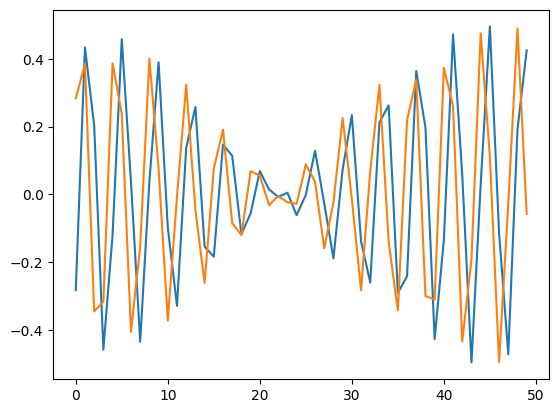

In [430]:
plt.plot(raw_signal[0][1])
plt.plot(raw_signal[0][0])

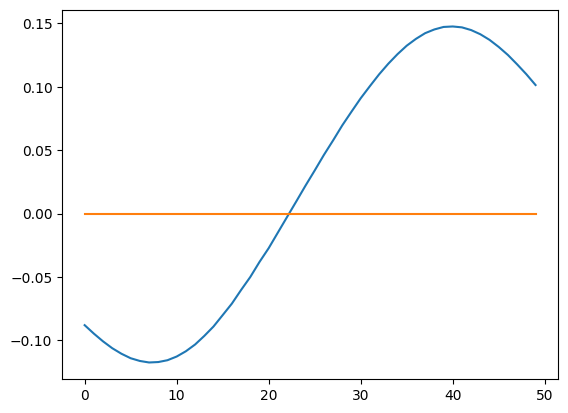

In [431]:
plt.plot(signal_matrix[1].real)
plt.plot(signal_matrix[1].imag)

In [432]:



theta=0
d=Detector(1e6) # 1Mhz sampling
sin_source_frequency=12e3 # 10khz signal 
wavelength=c/sin_source_frequency

d.add_source(SinSource([
      wavelength*100000*np.cos(theta),
      wavelength*100000*np.sin(theta)],
      sin_source_frequency,0))
  
d.add_receiver(Receiver([wavelength/8,0]))
d.add_receiver(Receiver([-wavelength/8,0]))
d.re

NameError: name 'Detector' is not defined

NOT NESTED
(2, 150)


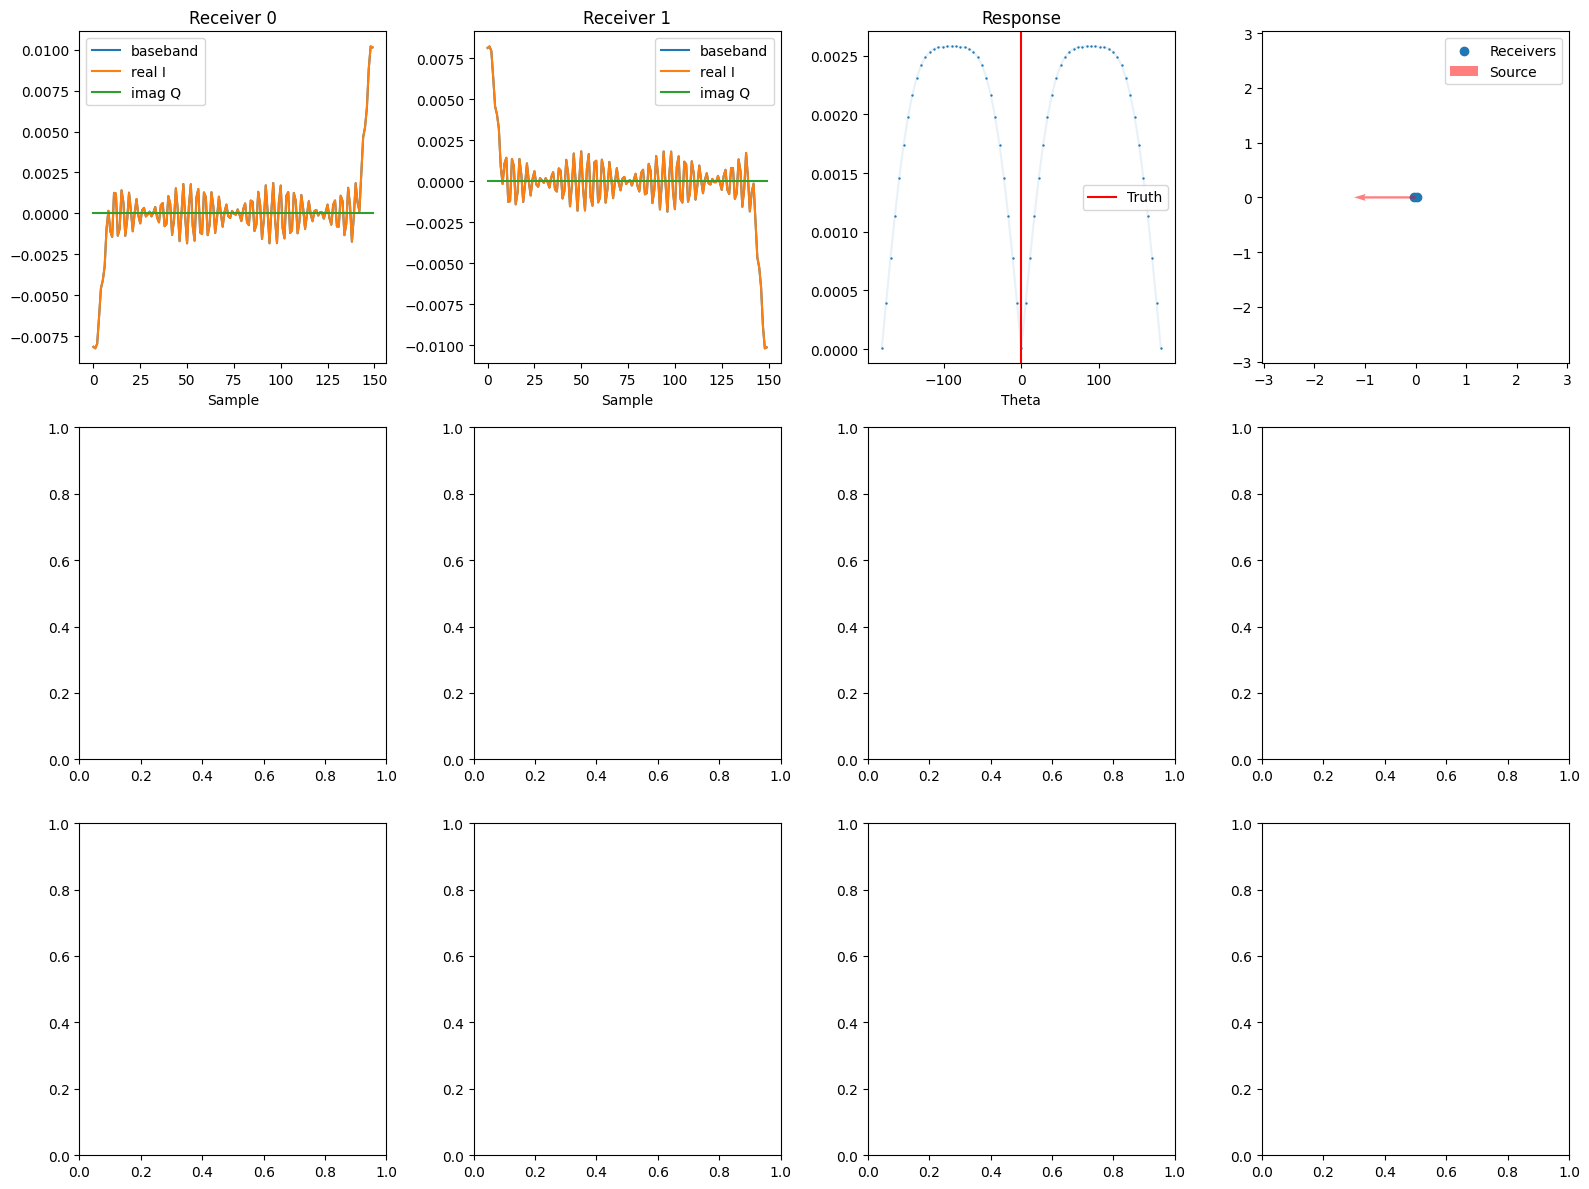

In [526]:

import rf
importlib.reload(rf)
from rf import beamformer 


def plot_space(ax,d):
  #fig,ax=plt.subplots(1,1,figsize=(4,4))
  receiver_pos=d.all_receiver_pos()
  _max=receiver_pos.max()
  _min=receiver_pos.min()
  buffer=max(3,int((_max-_min)*0.1))
  _max+=buffer
  _min-=buffer

  center_mass=receiver_pos.mean(axis=0)

  source_vectors=[ (source.pos-center_mass)/np.linalg.norm(source.pos-center_mass) for source in d.sources ]

  ax.set_xlim([_min,_max])
  ax.set_ylim([_min,_max])

  ax.scatter(receiver_pos[:,0],receiver_pos[:,1],label="Receivers")
  for source_vector in source_vectors:
    ax.quiver(center_mass[0], center_mass[1], 
              -source_vector[0], -source_vector[1], scale=5, alpha=0.5,color='red',label="Source")
  ax.legend()


n=3
fig,axs=plt.subplots(n,4,figsize=(4*4,4*n))
sample_rate=9.13e6
channel_frequency=100511
carrier_frequency=2.4e9

wavelength=c/carrier_frequency

for theta_idx,theta in enumerate(np.linspace(0,np.pi,n)):
  pos=np.array([
      wavelength*100*np.cos(theta),
      wavelength*100*np.sin(theta)])
    
  qam=rf.QAMSource(pos,
                   signal_frequency=channel_frequency,
                   sigma=0,
                   IQ=(1.0,1.0),
                    #h = signal.firwin(numtaps=151, cutoff=channel_frequency, fs=sample_rate)
                  )
  q=rf.CarrierSource(pos,
                   carrier_frequency,
                   qam,
                   h = signal.firwin(numtaps=19, cutoff=channel_frequency, fs=sample_rate)
                  )

  d=rf.ULADetector(sampling_frequency=sample_rate,n_elements=2,spacing=wavelength/2)
  d.add_source(q)
  signal_matrix,raw_signal,demod_times,sampling_times=d.get_signal_matrix(20+5e-7,150.0/sample_rate) 
  n_receivers=d.n_receivers()

  print(signal_matrix.shape)
  beam_thetas,beam_sds,steer=beamformer(
      d.all_receiver_pos(),
      signal_matrix,
      carrier_frequency)
  #print("RS",raw_signal[0].shape)

  for idx in range(signal_matrix.shape[0]):
    #axs[theta_idx][idx].plot(raw_signal[0][idx],label='Raw')
    axs[theta_idx][idx].plot(signal_matrix[idx].real+signal_matrix[idx].imag,label='baseband')
    axs[theta_idx][idx].plot(signal_matrix[idx].real,label='real I')
    axs[theta_idx][idx].plot(signal_matrix[idx].imag,label='imag Q')
    axs[theta_idx][idx].legend()
    axs[theta_idx][idx].set_title("Receiver %d" % idx)
    axs[theta_idx][idx].set_xlabel("Sample")
  
  beam_degrees=360*beam_thetas/(np.pi*2)
  axs[theta_idx][n_receivers].plot(beam_degrees,beam_sds,alpha=0.1)
  axs[theta_idx][n_receivers].scatter(beam_degrees,beam_sds,s=0.5)
  axs[theta_idx][n_receivers].axvline(x=360*theta/(2*np.pi),label="Truth",color='red')
  axs[theta_idx][n_receivers].set_title("Response")
  axs[theta_idx][n_receivers].set_xlabel("Theta")
  axs[theta_idx][n_receivers].legend()

  plot_space(axs[theta_idx][n_receivers+1],d)
  if theta_idx==0:
      break
fig.tight_layout()

In [508]:
raw_signal[0].shape,local.shape

((2, 150), (150,))

LOCAL (2, 150)
(2, 150)


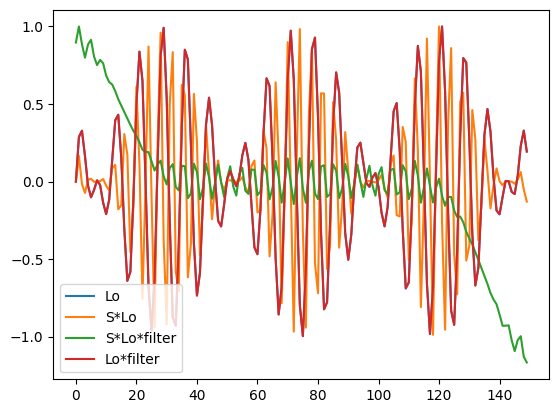

In [527]:
h = signal.firwin(numtaps=71, cutoff=channel_frequency, fs=sample_rate)
local=d.sources[0].signal(demod_times)
print("LOCAL",local.shape)
signal_if=raw_signal[0][0]*local
plt.plot(local[0]/local[0].max(),label="Lo")
plt.plot(signal_if[0]/signal_if[0].max(),label="S*Lo")
print(signal_if.shape)
signal_if_fil=np.array([np.convolve(x, h, mode='same') for x in signal_if ])

plt.plot(signal_if_fil[0]/signal_if_fil[0].max(),label="S*Lo*filter")
plt.plot(local[0]/local[0].max(),label="Lo*filter")
plt.legend()

100511 9130000.0
2400000000.0 100511 9130000.0
262.8696604600219


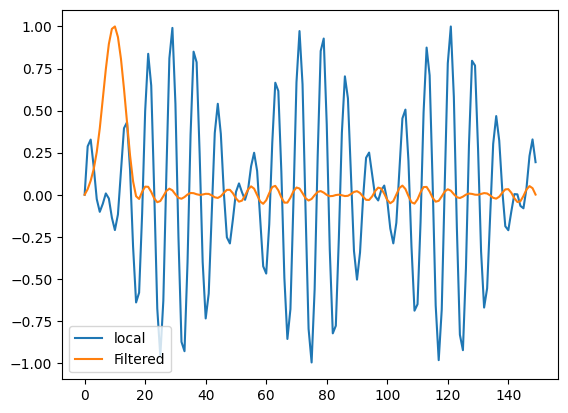

In [541]:
print(channel_frequency,sample_rate)

h = signal.firwin(numtaps=19, cutoff=[channel_frequency/2,channel_frequency], fs=sample_rate,pass_zero=False)

print(d.sources[0].carrier_frequency,channel_frequency,sample_rate)
print(d.sources[0].carrier_frequency/sample_rate)

local=d.sources[0].signal(demod_times)[0]
local_sin=d.sources[0].carrier_source.signal(sampling_times)[0]
#print(local_sin.shape)

a=1.0
local_sin_fil=signal.lfilter(h, a, local_sin) 
#local_sin_fil=np.convolve(local_sin, h, mode='same')

#local_fil=np.convolve(local, h, mode='same')
local_fil=signal.lfilter(h, a, local) 
#print(local.shape,local_fil.shape)

plt.plot(local/local.max(),label="local")
#plt.plot(local_sin/local_sin.max())

#plt.plot(local_sin_fil/local_sin_fil.max(),label="Filtered Sin")
plt.plot(local_fil/local_fil.max(),label="Filtered")
plt.legend()

In [158]:
z=np.array([
    [1,0,0],
    [0,1,0],
    [1,0,0],
    [1,0,1]
])
np.cumsum(z,axis=1)

array([[1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 2]])